## 1. Instalación y Setup

In [ ]:
!pip install torchvision gdown

import os
import zipfile
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch import nn, optim
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("⚠️ GPU no disponible, se usará CPU")

✅ GPU disponible: Tesla T4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo usado para entrenar:", device)

Dispositivo usado para entrenar: cuda


## 2. Descargar y preparar dataset UTKFace

In [ ]:
import gdown

# Descargar el archivo zip
file_id = "12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx"
output_zip = "UTKFace.zip"

if not os.path.exists(output_zip):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Descomprimir
if not os.path.exists("UTKFace"):
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall("UTKFace")


Downloading...
From (original): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx
From (redirected): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx&confirm=t&uuid=bef81e2f-36d1-409a-a3ce-6799ea83ff37
To: /content/UTKFace.zip
100%|██████████| 1.40G/1.40G [00:21<00:00, 63.6MB/s]


## 3. Definir funciones y filtrar imágenes de hombres con validación de nombre

In [ ]:
dataset_path = "UTKFace"
female_images = []

def get_age_category(age):
    if age <= 3:
        return 0
    elif age <= 12:
        return 1
    elif age <= 23:
        return 2
    elif age <= 30:
        return 3
    elif age <= 44:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6

for fname in os.listdir(dataset_path):
    if fname.endswith((".jpg", ".png")):
        partes = fname.split("_")
        if len(partes) >= 4 and partes[0].isdigit() and partes[1].isdigit():
            age = int(partes[0])
            gender = int(partes[1])
            if gender == 1:  # Solo mujeres (1 = female)
                female_images.append((fname, get_age_category(age)))

## 4. Análisis de distribución por clase

📊 Cantidad de imágenes por rango etario:
        Rango etario  Cantidad
          Bebé (0-3)      1054
         Niña (4-12)       917
 Adolescente (13-23)      1625
Joven Adulto (24-30)      3708
      Adulto (31-44)      2088
Adulto Mayor (45-60)      1094
       Anciana (>60)      1035


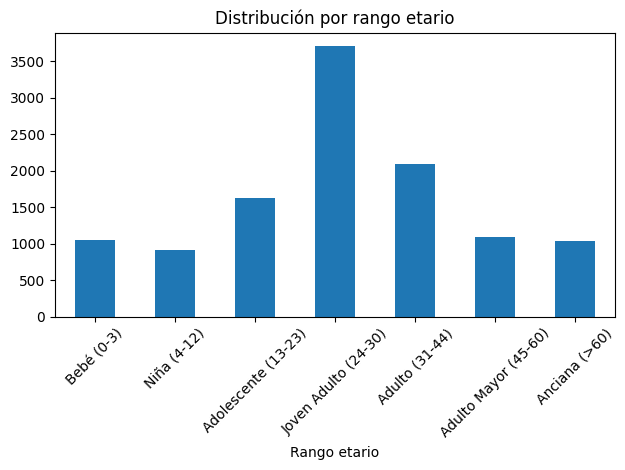

In [ ]:
label_names = [
    "Bebé (0-3)", "Niña (4-12)",
    "Adolescente (13-23)", "Joven Adulto (24-30)", "Adulto (31-44)",
    "Adulto Mayor (45-60)", "Anciana (>60)"
]

labels = [label for _, label in female_images]
class_counts = Counter(labels)

df = pd.DataFrame({
    'Rango etario': label_names,
    'Cantidad': [class_counts.get(i, 0) for i in range(7)]
})

print("📊 Cantidad de imágenes por rango etario:")
print(df.to_string(index=False))

df.plot(kind='bar', x='Rango etario', y='Cantidad', legend=False, title="Distribución por rango etario")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Calcular pesos por clase

In [ ]:
total = sum(class_counts.values())
class_weights = [total / (class_counts.get(i, 0) + 1e-6) for i in range(7)]
class_weights = [w / sum(class_weights) for w in class_weights]
print("Pesos por clase:", class_weights)


Pesos por clase: [0.17957030243782318, 0.20639814475751123, 0.1164720608200393, 0.05104290693041883, 0.09064516228850134, 0.17300466067278908, 0.18286676209291708]


## 6. Preparar dataset y transformaciones

In [ ]:
train_imgs, val_imgs = train_test_split(female_images, test_size=0.2, random_state=42)

class UTKFaceDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.data = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(dataset_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformaciones para entrenamiento (con aumentos)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transformaciones para validación (solo resize y normalización)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = UTKFaceDataset(train_imgs, transform=transform_train)
val_dataset = UTKFaceDataset(val_imgs, transform=transform_val)


## 7. Definir modelo con densenet121 preentrenada congelada

In [ ]:
class AgeClassifier(nn.Module):
    def __init__(self, base_model_name='densenet121', num_classes=7):
        super().__init__()

        if base_model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)

        elif base_model_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
            num_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_features, num_classes)

        elif base_model_name == 'densenet121':
            self.model = models.densenet121(pretrained=True)
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, num_classes)

        else:
            raise ValueError(f"Modelo '{base_model_name}' no soportado")

    def forward(self, x):
        return self.model(x)

## 8. Entrenar 4 modelos con early stopping

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_configs = [
    {"name": "Modelo A", "lr": 0.00015, "batch_size": 32, "epochs": 30},
    {"name": "Modelo B", "lr": 0.00025, "batch_size": 48, "epochs": 30},
    {"name": "Modelo C", "lr": 0.0001, "batch_size": 64, "epochs": 30},
    {"name": "Modelo D", "lr": 0.00035, "batch_size": 40, "epochs": 30},
]

for config in model_configs:
    print(f"\n🎯 Entrenando {config['name']}")
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = AgeClassifier(base_model_name='densenet121').to(device)

    # Optimizar solo parámetros entrenables (layer4 y fc)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config["lr"])

    # Scheduler para ajustar learning rate según val_loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    weights_tensor = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    best_loss = float('inf')
    no_improve = 0

    for epoch in range(config["epochs"]):
        print(f"📈 {config['name']} - Época {epoch + 1}/{config['epochs']}")

        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)  # <--- CORRECCIÓN: Promediar train_loss

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Ajustar learning rate según val_loss
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            model_filename = f"{config['name'].replace(' ', '_')}_age_model_female_densenet121.pt"
            torch.save(model, model_filename)
            print(f"✅ Modelo guardado: {model_filename}")
        else:
            no_improve += 1
            if no_improve >= 5:
                print("⛔ Early stopping.")
                break


🎯 Entrenando Modelo A
📈 Modelo A - Época 1/30
🔍 train_loss=1.1354, val_loss=0.9643
✅ Modelo guardado: Modelo_A_age_model_female_densenet121.pt
📈 Modelo A - Época 2/30
🔍 train_loss=0.8385, val_loss=0.9246
✅ Modelo guardado: Modelo_A_age_model_female_densenet121.pt
📈 Modelo A - Época 3/30
🔍 train_loss=0.7263, val_loss=0.9056
✅ Modelo guardado: Modelo_A_age_model_female_densenet121.pt
📈 Modelo A - Época 4/30
🔍 train_loss=0.6113, val_loss=0.9219
📈 Modelo A - Época 5/30
🔍 train_loss=0.5313, val_loss=0.9377
📈 Modelo A - Época 6/30
🔍 train_loss=0.4403, val_loss=0.9989
📈 Modelo A - Época 7/30
🔍 train_loss=0.3850, val_loss=1.1214
📈 Modelo A - Época 8/30
🔍 train_loss=0.2308, val_loss=1.1724
⛔ Early stopping.

🎯 Entrenando Modelo B
📈 Modelo B - Época 1/30
🔍 train_loss=1.1189, val_loss=1.0111
✅ Modelo guardado: Modelo_B_age_model_female_densenet121.pt
📈 Modelo B - Época 2/30
🔍 train_loss=0.8549, val_loss=0.9187
✅ Modelo guardado: Modelo_B_age_model_female_densenet121.pt
📈 Modelo B - Época 3/30
🔍 

# 8.1 FineTunning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 🔁 Cargamos el modelo previamente entrenado
model_path = "Modelo_C_age_model_female_densenet121.pt"

# Detectamos dispositivo: GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo completo en el dispositivo
# map_location asegura que se cargue en la GPU o CPU correcta
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)

# 🔓 Descongelamos las capas layer3, layer4 y fc para entrenarlas (fine-tuning)
# Congelamos todas las demás para evitar modificar parámetros ya entrenados en esas capas
for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer3", "layer4", "fc"]):
        param.requires_grad = True  # Estas capas serán entrenadas
    else:
        param.requires_grad = False  # El resto queda congelado

# 🧪 Definimos optimizador Adam para solo parámetros entrenables con learning rate bajo y weight decay para regularización
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

# Función de pérdida CrossEntropy con pesos para balancear clases desbalanceadas
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Scheduler para reducir learning rate si no hay mejora en validación en 2 épocas (paciencia=2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Creamos DataLoaders para entrenamiento y validación con batch size fijo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 🎯 Loop de fine-tuning
best_loss = float('inf')  # Mejor pérdida inicial muy alta
no_improve = 0  # Contador para early stopping
max_epochs = 10  # Máximo número de épocas para fine-tuning
finetuned_path = "Modelo_C_finetuned_Desnet.pt"  # Archivo donde se guardará el modelo mejorado

print("🎯 Fine-tuning del Modelo (layer3, layer4, fc)")

for epoch in range(max_epochs):
    print(f"📈 Época {epoch + 1}/{max_epochs}")

    # 🔁 Entrenamiento: habilitamos modo train para activar dropout, batchnorm, etc.
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Pasamos datos a GPU/CPU
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculamos pérdida
        optimizer.zero_grad()  # Limpiamos gradientes previos
        loss.backward()  # Backward pass: calcula gradientes
        optimizer.step()  # Actualiza pesos en capas descongeladas
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)  # Promedio pérdida entrenamiento

    # 🧪 Validación: modo eval desactiva dropout, batchnorm en modo eval
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No calculamos gradientes para acelerar y ahorrar memoria
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)  # Promedio pérdida validación

    print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # Scheduler reduce LR si no mejora la pérdida de validación
    scheduler.step(val_loss)

    # Early stopping: guardamos modelo si mejora, si no contamos épocas sin mejora
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(model, finetuned_path)  # Guardamos modelo mejorado
        print(f"✅ Modelo mejorado guardado como: {finetuned_path}")
    else:
        no_improve += 1
        if no_improve >= 2:
            print("⛔ Early stopping por no mejora.")
            break  # Salimos del loop para evitar sobreajuste

🎯 Fine-tuning del Modelo (layer3, layer4, fc)
📈 Época 1/10
🔍 train_loss=0.7211, val_loss=0.6851
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 2/10
🔍 train_loss=0.7058, val_loss=0.6787
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 3/10
🔍 train_loss=0.6926, val_loss=0.6706
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 4/10
🔍 train_loss=0.6920, val_loss=0.6696
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 5/10
🔍 train_loss=0.6902, val_loss=0.6639
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 6/10
🔍 train_loss=0.6770, val_loss=0.6591
✅ Modelo mejorado guardado como: Modelo_C_finetuned_Desnet.pt
📈 Época 7/10
🔍 train_loss=0.6726, val_loss=0.6613
📈 Época 8/10
🔍 train_loss=0.6748, val_loss=0.6593
⛔ Early stopping por no mejora.


# 9. Evaluación de los modelos entrenados


📊 Evaluando Modelo_C_finetuned_Desnet
✅ Accuracy: 67.20%
📉 MAE: 2.95 años
📊 Desvío estándar del error: 5.05
🎯 Precision (weighted): 0.6788
🎯 Recall (weighted): 0.6720
🎯 F1-Score (weighted): 0.6730


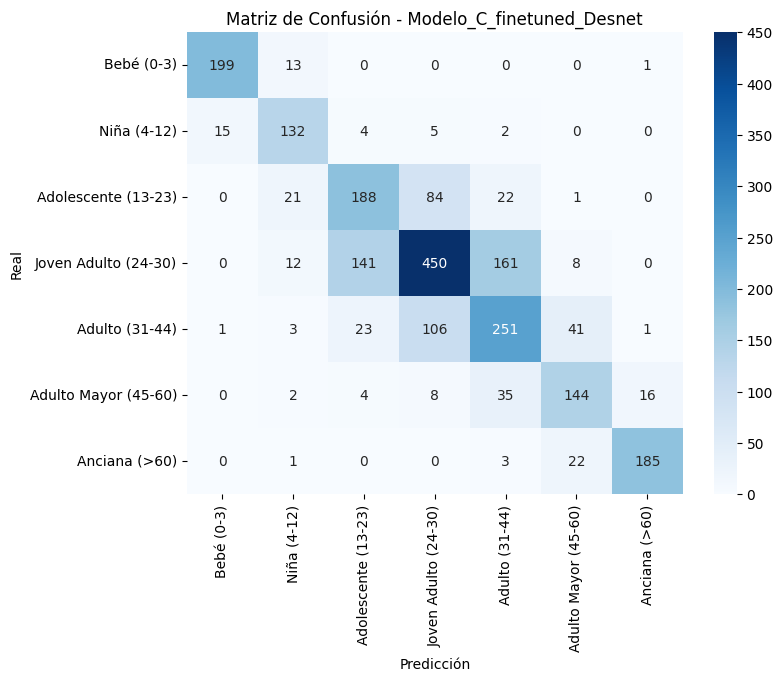

📋 Reporte de clasificación:
                      precision    recall  f1-score   support

          Bebé (0-3)       0.93      0.93      0.93       213
         Niña (4-12)       0.72      0.84      0.77       158
 Adolescente (13-23)       0.52      0.59      0.56       316
Joven Adulto (24-30)       0.69      0.58      0.63       772
      Adulto (31-44)       0.53      0.59      0.56       426
Adulto Mayor (45-60)       0.67      0.69      0.68       209
       Anciana (>60)       0.91      0.88      0.89       211

            accuracy                           0.67      2305
           macro avg       0.71      0.73      0.72      2305
        weighted avg       0.68      0.67      0.67      2305



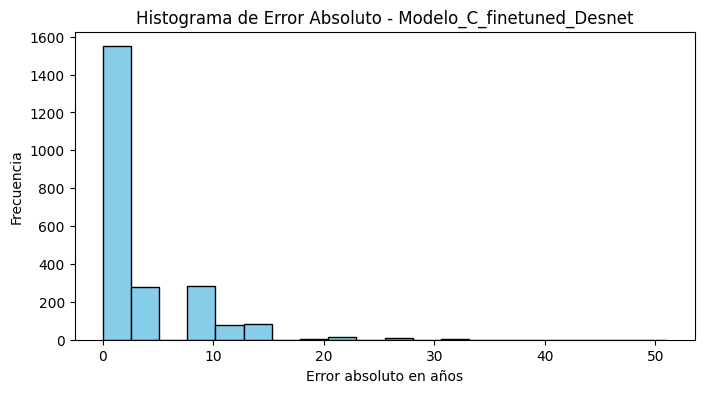

/tmp/ipython-input-12-2249310199.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


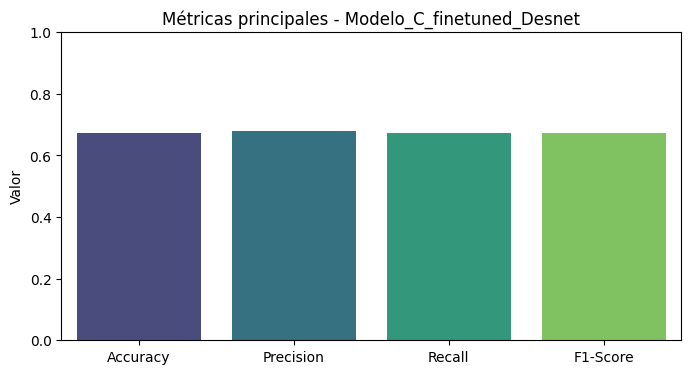

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

def plot_metric_bar(metrics, title):
    plt.figure(figsize=(8,4))
    names = list(metrics.keys())
    values = list(metrics.values())
    sns.barplot(x=names, y=values, palette="viridis")
    plt.ylim(0,1)
    plt.title(title)
    plt.ylabel('Valor')
    plt.show()

model_names = ["Modelo_C_finetuned_Desnet"]

def rango_to_edad_promedio(cat):
    return [1.5, 6.5, 11.5, 16.5, 25, 37.5, 52.5, 70][cat]


for name in model_names:
    model_path = f"{name}.pt"
    if os.path.exists(model_path):
        print(f"\n📊 Evaluando {name}")

        model = torch.load(model_path, map_location=device, weights_only=False)
        model.eval()

        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        errores = []
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                edad_real = [rango_to_edad_promedio(l.item()) for l in labels]
                edad_pred = [rango_to_edad_promedio(p.item()) for p in predicted]
                errores += list(np.abs(np.array(edad_real) - np.array(edad_pred)))

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        errores = np.array(errores)
        accuracy = 100 * correct / total
        mae = errores.mean()
        std = errores.std()

        # Métricas clásicas para clasificación
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"✅ Accuracy: {accuracy:.2f}%")
        print(f"📉 MAE: {mae:.2f} años")
        print(f"📊 Desvío estándar del error: {std:.2f}")
        print(f"🎯 Precision (weighted): {precision:.4f}")
        print(f"🎯 Recall (weighted): {recall:.4f}")
        print(f"🎯 F1-Score (weighted): {f1:.4f}")

        # Mostrar matriz de confusión
        cm = confusion_matrix(all_labels, all_preds)
        plot_confusion_matrix(cm, label_names, title=f'Matriz de Confusión - {name}')

        # Reporte detallado de clasificación
        print("📋 Reporte de clasificación:")
        print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

        # Histograma de errores absolutos
        plt.figure(figsize=(8,4))
        plt.hist(errores, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histograma de Error Absoluto - {name}')
        plt.xlabel('Error absoluto en años')
        plt.ylabel('Frecuencia')
        plt.show()

        # Gráfico de métricas principales
        metrics = {
            'Accuracy': accuracy/100,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        plot_metric_bar(metrics, title=f'Métricas principales - {name}')

    else:
        print(f"⚠️ Modelo {name} no encontrado.")

# 10. Probar Modelo


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import os

# 🧠 Seleccionar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Modelo cargado
model_path = "Modelo_B_finetuned.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)
model.eval()

# Rango etario por clase
age_ranges = [
    "0-3 (Bebé)",
    "4-9 (Niño)",
    "10-13 (Preadolescente)",
    "14-19 (Adolescente)",
    "20-30 (Joven adulto)",
    "31-44 (Adulto)",
    "45-60 (Adulto mayor)",
    "61+ (Anciano)"
]

# 🔍 Elegimos 5 imágenes de prueba al azar
samples = random.sample(val_imgs, 5)

# 🔁 Mostrar resultados
for img_name, true_class in samples:
    img_path = os.path.join(dataset_path, img_name)
    image_pil = Image.open(img_path).convert("RGB")

    # ✅ Obtener edad real desde el nombre del archivo
    real_age = int(img_name.split("_")[0])

    # Preprocesar imagen
    image_tensor = transform_val(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = output.argmax(dim=1).item()

    # Mostrar
    predicted_range = age_ranges[predicted_class]

    plt.imshow(image_pil)
    plt.axis("off")
    plt.title(f"🧠 Predicho: {predicted_range}\n✅ Edad real: {real_age} años")
    plt.show()

AttributeError: Can't get attribute 'AgeClassifierResNet' on <module '__main__'>